# Actual vs Fitted

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from utils import dbObj

Get some data. Choose gilts with redemption date at least 2 years. It seems the estimated yields do a better fit for these time horisons

In [2]:
sqlStr = " select g.Close_of_Business_Date, g.ISIN_Code, g.Redemption_Date, "
sqlStr += " g.Dirty_Price, g.Yield, y.[Estimated Yield], "
sqlStr += " g.Yield-y.[Estimated Yield] as yield_diff "
sqlStr += " from Research.dbo.gilts g "
sqlStr += " left outer join [Research].[dbo].[est_yield] y "
sqlStr += " on g.Close_of_Business_Date = y.Close_of_Business_Date "
sqlStr += " and "
sqlStr += " g.ISIN_Code = y.ISIN_Code "
sqlStr += " and "
sqlStr += " g.Redemption_Date = y.Redemption_Date "
sqlStr += " where g.Close_of_Business_Date > '01-Nov-2012' "
sqlStr += " and datediff(year, g.Close_of_Business_Date, g.Redemption_Date) >= 2 "

In [3]:
engine = dbObj()
connection = engine.connect()

In [4]:
rs = pd.read_sql(sqlStr, connection, index_col=['Close_of_Business_Date', 'ISIN_Code'])
connection.dispose()
rs.head()

,,Redemption_Date,Dirty_Price,Yield,Estimated Yield,yield_diff
Close_of_Business_Date,ISIN_Code,,,,,
2012-11-02,GB0000512359,2014-06-07,99.626667,0.235759,0.177817,0.057942
2012-11-05,GB0000512359,2014-06-07,99.673427,0.206523,0.144423,0.062100
2012-11-06,GB0000512359,2014-06-07,99.673061,0.207112,0.137145,0.069967
2012-11-07,GB0000512359,2014-06-07,99.695626,0.193122,0.111893,0.081229
2012-11-08,GB0000512359,2014-06-07,99.689181,0.197562,0.124483,0.073079


Get the residuals (ie how much the actual yield is above or below the fitted one). To do this, from the rs dataframe drop all columns apart from 'Close_of_Business_Date', 'ISIN_Code' and 'yield_diff'

In [5]:
resid = rs.drop(['Redemption_Date', 'Estimated Yield', 'Yield', 'Dirty_Price'], axis=1)
resid = resid.unstack()
del resid.index.name
resid.columns = resid.columns.droplevel()
resid.index = pd.to_datetime(resid.index)
resid.iloc[:,:4].head() #show the first few

ISIN_Code,GB0000512359,GB0000513431,GB0000513654,GB0000513878
2012-11-02,0.057942,-0.007396,-0.057405,-0.093270
2012-11-05,0.062100,-0.007705,-0.061149,-0.099661
2012-11-06,0.069967,-0.002521,-0.058433,-0.099136
2012-11-07,0.081229,0.003053,-0.057583,-0.102323
2012-11-08,0.073079,-0.003694,-0.062885,-0.106072


Score: 1 if actual yield is above the fitted, -1 if actual yield is below

In [6]:
score = resid.apply(np.sign)
score.iloc[:,:4].head() #show the first few

ISIN_Code,GB0000512359,GB0000513431,GB0000513654,GB0000513878
2012-11-02,1,-1,-1,-1
2012-11-05,1,-1,-1,-1
2012-11-06,1,-1,-1,-1
2012-11-07,1,1,-1,-1
2012-11-08,1,-1,-1,-1


Get the bond prices (from the rs dataframe drop all columns apart from 'Close_of_Business_Date', 'ISIN_Code' and 'Dirty_Price')

In [7]:
p = rs.drop(['Redemption_Date', 'Estimated Yield', 'Yield', 'yield_diff'], axis=1)
p = p.unstack()
del p.index.name
p.columns = p.columns.droplevel()
p.index = pd.to_datetime(p.index)
p.iloc[:,:4].head() #show the first few

ISIN_Code,GB0000512359,GB0000513431,GB0000513654,GB0000513878
2012-11-02,99.626667,99.388662,99.063452,98.634031
2012-11-05,99.673427,99.460420,99.162296,98.761110
2012-11-06,99.673061,99.464810,99.173234,98.779825
2012-11-07,99.695626,99.510227,99.246322,98.884646
2012-11-08,99.689181,99.500004,99.231464,98.864063


Bond returns

In [8]:
ret = p.pct_change()
ret.iloc[:,:4].head() #show the first few

ISIN_Code,GB0000512359,GB0000513431,GB0000513654,GB0000513878
2012-11-02,NaN,NaN,NaN,NaN
2012-11-05,0.000469,0.000722,0.000998,0.001288
2012-11-06,-0.000004,0.000044,0.000110,0.000189
2012-11-07,0.000226,0.000457,0.000737,0.001061
2012-11-08,-0.000065,-0.000103,-0.000150,-0.000208


Partition the residuals into buckets

In [9]:
q = resid.apply(lambda x: pd.qcut(x, 5, labels=list(range(5))), axis=1)
q.iloc[:,:4].head() #show the first few

ISIN_Code,GB0000512359,GB0000513431,GB0000513654,GB0000513878
2012-11-02,4,1,0,0
2012-11-05,4,1,0,0
2012-11-06,4,1,0,0
2012-11-07,4,2,1,0
2012-11-08,4,1,0,0


Keep only scores for the top and bottom buckets (ie those whose actual yield is very high (q=4) or very low (q=0) compared to the fitted yield)

In [10]:
score = score[(q == 0) | (q == 4)]
score.iloc[:,:4].head() #show the first few

ISIN_Code,GB0000512359,GB0000513431,GB0000513654,GB0000513878
2012-11-02,1,NaN,-1,-1
2012-11-05,1,NaN,-1,-1
2012-11-06,1,NaN,-1,-1
2012-11-07,1,NaN,NaN,-1
2012-11-08,1,NaN,-1,-1


Portfolio PnL for each day:
For each gilt and for each day multiply the score with the next day's return. Then for each day, sum over the gilts

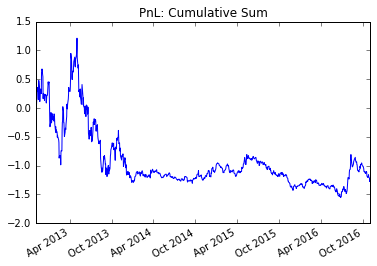

In [11]:
port_pnl = score.shift().multiply(ret).sum(axis=1)
port_pnl.cumsum().plot(title='PnL: Cumulative Sum')
port_pnl.to_clipboard()

Sharpe ratio:

In [12]:
sr = np.mean(port_pnl) / np.std(port_pnl) * np.sqrt(250)
print "Annualised Sharpe ratio is %2.2f" % sr

Annualised Sharpe ratio is -0.31


# Notes:
* It is clear from the Sharpe ratio that the strategy doesnt seem to perform well.
* For each day, the strategy splits the gilts into equally sized buckets based on how much the actual yield exceeds or falls behind the model fitted yield. Then it selects only the top and bottom buckets and assigns the score of 1 if actual yield is above the fitted or -1 if observed yield is below. Effectively this means that on each gilt you allocate the same amount of capital and the long and short side will cancel each out since they contain equal number of securities. Hence the strategy is USD neutral. 